In [1]:
import pandas as pd
import numpy as np
path = 'dataset/labelled_tweets.csv'
    
tweet = pd.read_csv(path, usecols=['text', 'polarity'])
# Remove rows will nan values
tweet = tweet.dropna()
tweet = tweet.reindex(np.random.permutation(tweet.index))
# preprocessing bit
# replace user handles (@Jumia) to be empty
pattern = "(@[A-Za-z0-9]+)|(http|https|ftp)://[a-zA-Z0-9./]+|#(\w+)"
tweet['text'] = tweet.text.str.replace(pattern, '')
tweet.head()

,polarity,text
1392,negative,why are you guys not responding to my emails ...
972,neutral,My order number is 309629596
453,negative,ORDER N.° 30429438 i have picked my package t...
1564,neutral,Okay but the 21 days max are elapsing this week..
1466,negative,I need a way forward. Am tired and remember n...


In [2]:
# examine class distribution
tweet.polarity.value_counts()

neutral     959
negative    748
positive    100
Name: polarity, dtype: int64

In [3]:
# convert label to a numerical count by creating a new column
tweet['polarity_num'] = tweet.polarity.map({'negative':0,'positive':1,'neutral':2})

In [4]:
# Define X matrix as features and y as vectors
X = tweet.text
y = tweet.polarity_num
print(X.shape)
print(y.shape)

(1807,)
(1807,)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1355,)
(452,)
(1355,)
(452,)


### Model evaluation

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import re
import numpy as np

In [14]:
clf_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
clf_nb = clf_nb.fit(X_train,y_train)
y_pred_nb = clf_nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_nb))
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, y_pred_nb))

             precision    recall  f1-score   support

          0       0.79      0.72      0.76       203
          1       0.00      0.00      0.00        27
          2       0.70      0.84      0.76       222

avg / total       0.70      0.74      0.72       452

MultinomialNB Accuracy:  0.738938053097


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM

In [19]:
clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, n_iter=5,random_state=42))])
clf_svm = clf_svm.fit(X_train,y_train)
y_pred_svm = clf_svm.predict(X_test)
print(metrics.classification_report(y_test, y_pred_svm))
print("SGDClassifier Accuracy: ", metrics.accuracy_score(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.80      0.76      0.78       203
          1       0.75      0.22      0.34        27
          2       0.74      0.83      0.78       222

avg / total       0.77      0.77      0.76       452

SGDClassifier Accuracy:  0.765486725664


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
clf_reg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
clf_reg = clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_reg))
print("SGDClassifier Accuracy: ", metrics.accuracy_score(y_test, y_pred_reg))

             precision    recall  f1-score   support

          0       0.83      0.72      0.77       203
          1       0.75      0.11      0.19        27
          2       0.72      0.87      0.79       222

avg / total       0.77      0.76      0.75       452

SGDClassifier Accuracy:  0.761061946903


### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV 
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), }

In [ ]:
clf_list = [clf_nb, clf_reg, clf_svm]
clf_dict = {
    clf_nb : {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),},
    clf_reg : {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), },
    clf_svm : {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),}
}

scores = {}
# loop every key and value in the dictionary
for clf, params in clf_dict.items():
    gs_clf = GridSearchCV(clf, params, n_jobs=-1, cv=10)
    gs_clf = gs_clf.fit(X_train, y_train)
    scores[clf] = gs_clf.best_score_



# for clf in clf_list:
#     gs_clf = GridSearchCV(clf, parameters, n_jobs=-1, cv=10)
#     gs_clf = gs_clf.fit(X_train, y_train)
#     print(gs_clf.best_score_)

In [ ]:
scores = joblib.load('scores.pkl')
maximum = max(scores, key=scores.get)  # Just use 'min' instead of 'max' for minimum.
print(maximum, scores[maximum])
# scores

In [ ]:
gs_clf.best_score_

In [ ]:
gs_clf.best_params_

### Model persistence

In [ ]:
# pickle the scores for faster access
from sklearn.externals import joblib
joblib.dump(scores, 'scores.pkl') 

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
from sklearn.metrics import classification_report
metrics.accuracy_score(y_test, y_pred_class)
print(classification_report(y_test, y_pred_class))

In [ ]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)

In [ ]:
from sklearn.model_selection import cross_val_score
logreg = MultinomialNB()
print(cross_val_score(logreg, X_dtm, y, cv=10, scoring='accuracy').mean())

### Confusion Matrix


This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Confusion matrix, without normalization
[[147   0  56]
 [  3   0  24]
 [ 35   0 187]]
Normalized confusion matrix
[[ 0.72  0.    0.28]
 [ 0.11  0.    0.89]
 [ 0.16  0.    0.84]]


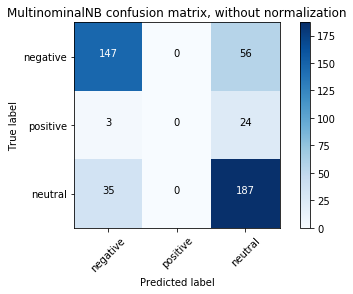

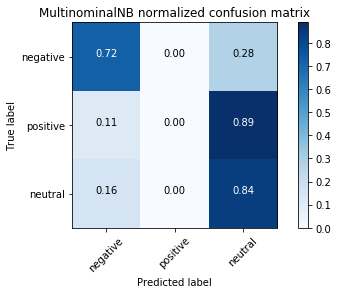

Confusion matrix, without normalization
[[147   0  56]
 [  3   3  21]
 [ 27   1 194]]
Normalized confusion matrix
[[ 0.72  0.    0.28]
 [ 0.11  0.11  0.78]
 [ 0.12  0.    0.87]]


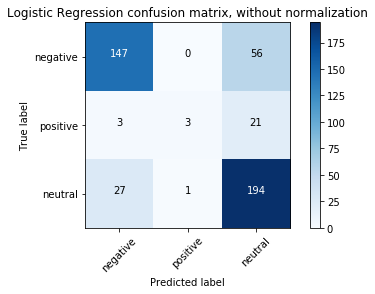

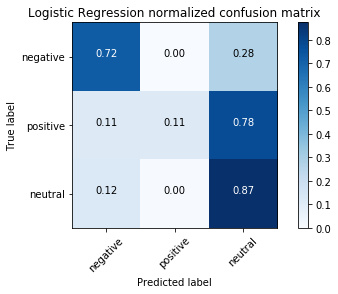

Confusion matrix, without normalization
[[155   0  48]
 [  4   6  17]
 [ 35   2 185]]
Normalized confusion matrix
[[ 0.76  0.    0.24]
 [ 0.15  0.22  0.63]
 [ 0.16  0.01  0.83]]


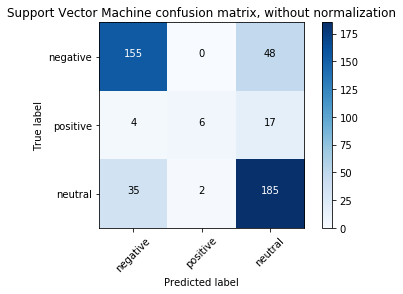

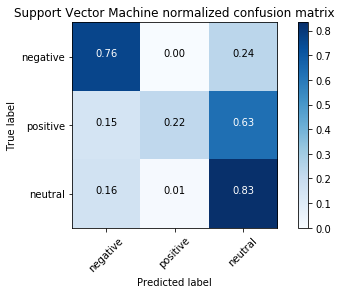

In [39]:
"""
This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['negative','positive','neutral']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for all predicted y

predicted_y = [y_pred_nb, y_pred_reg, y_pred_svm]

titles = ['MultinominalNB', 'Logistic Regression', 'Support Vector Machine']

for index, y_prediction in enumerate(predicted_y):
    cnf_matrix = confusion_matrix(y_test, y_prediction)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=titles[index] + ' confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=titles[index] + ' normalized confusion matrix')

    plt.show()

In [ ]:
clf_svm.predict(['OK'])

# Topic Modelling

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
order number status delivered hi
Topic 1:
thank ok yes delivered response
Topic 2:
com twitter pic https jumia
Topic 3:
thanks ok alright got sorted
Topic 4:
dm follow check send did
Topic 5:
cancel order like want need
Topic 6:
delivery pay option hello hi
Topic 7:
okay check week boss tomorrow
Topic 8:
waiting reply feedback ll weeks
Topic 9:
kindly check confirm hi email
Topic 0:
thank bn item pick point
Topic 1:
day error generic supplier save
Topic 2:
use hope email 300 code
Topic 3:
okay waiting right patient bit
Topic 4:
order kindly number delivery hi
Topic 5:
price tv tecno 32 plus
Topic 6:
ni hours 48 uko wapi
Topic 7:
package time guys sent details
Topic 8:
com thanks twitter pic jumia
Topic 9:
bought replace long tried started


In [35]:
nmf.components_.shape

(20, 1000)

### NMF and LDA Summarized Topics

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 2

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

no_top_words = 4
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, X, no_top_words, no_top_documents)
display_topics(lda_H, lda_W, tf_feature_names, X, no_top_words, no_top_documents)

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
order cancel number kindly
 hi.I've tried calling the no. you used to call me but the response is that it's out of service
Kindly expedite.
Its a phone and am in kabarnet
 you don't serve people as they wish,why would you council orders your customers do!?!! 
Topic 1:
thank okay ok yes
 please inform on order 304296586 posta stuff have record of not calling citing lack of credit.... please help
 Kindly update me on status of order 301131186, the online tracking hasn't updated since 10th August.
how much is this
 what's the status on my order 306865686 am not being notified.
Topic 0:
order number delivery kindly
Hallo Jumia, I had paid upfront for this stuff and by bad luck, I have deleted the txt msg for iPAY. I hope on delivery day no problem.
 I wanna Order the Infinix Note 4 to be delivered within town.
Am in kisii how soon can get this
 I made an order more than three weeks ago,Im yet to b informed whether the product is arrived.
Topic 1:
com thanks twitter pic
Noted
 How 

In [37]:
titles[0]

'MultinominalNB'

In [36]:
for i, title in enumerate(titles):
    print(i)

0
1
2
